In [421]:
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, roc_curve, roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
engine = create_engine('postgresql://localhost:5432/wa_leg_staging')

In [27]:
merged_final_df = pd.read_sql_query('select * from "merged_final"',con=engine)
bill_text_df = pd.read_sql_query('select * from "bill_text"',con=engine)
rep_score_df = pd.read_sql_query('select * from "rep_score"',con=engine)
loyalty_df = pd.read_sql_query('select * from "loyalty"',con=engine)

In [41]:
def create_clean_X(merged_final_df, bill_text_df, rep_score_df, loyalty_df):
    
    # Add bill_text
    clean = merged_final_df.merge(bill_text_df, how='left', on=['unique_id', 'htm_url'])
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    clean.rename(columns={'sponsor_party': 'primary_sponsor_party'}, inplace=True)

    
    # Add rep_score and replace -1 values, then make dem_score
    clean['bill_num'] = clean['bill_id'].apply(lambda x: x.split()[1])
    clean['bill_num_unique'] = clean['biennium'] + ' ' + clean['bill_num']
    clean = clean.merge(rep_score_df, how='left', on='bill_num_unique')

    def replace_with_p_sponsor_party(row):
        primary_sponsor_party = row['primary_sponsor_party']
        if row['rep_score'] == -1:
            return primary_sponsor_party
        else:
            return row['rep_score']
    clean['rep_score'] = clean.apply(replace_with_p_sponsor_party, axis=1)
    clean['dem_score'] = 1 - clean['rep_score']
    
    
    # Add loyalty scores
    clean = clean.merge(loyalty_df, how = 'left', on='voter_id')
    clean.drop(['index_x', 'index_y'], axis=1, inplace=True)
    
    
    # Feature Engineering functions
    def create_congress_nums(biennium):
        '''Numbers bienniums so that 1991 is 1 and 1993 is 3.'''
        first_year = int((biennium.split('-'))[0])
        return first_year - 1990
    
    def find_num_sponsors(secondary_sponsors):
        if type(secondary_sponsors) == str:
            return len(secondary_sponsors)
        else: return 1
    
    # Feature Engineering
    clean['bill_length'] = clean['bill_text'].apply(lambda x: len(x))
    clean['congress_num'] = clean['biennium'].apply(create_congress_nums)
    clean['num_sponsors'] = clean['secondary_sponsors'].apply(find_num_sponsors)

    return clean

In [42]:
clean = create_clean_X(merged_final_df, bill_text_df, rep_score_df, loyalty_df)

In [43]:
clean.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,loyalty_score,bill_length,congress_num,num_sponsors
0,1,1993-02-16,347,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,"{445,309,339,562}",562,0.5,0.5,0.153989,34836,3,17
1,1,1993-02-16,360,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,"{445,309,339,562}",562,0.5,0.5,0.101553,34836,3,17
2,1,1993-02-16,361,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,"{445,309,339,562}",562,0.5,0.5,-0.105107,34836,3,17
3,1,1993-02-16,387,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,"{445,309,339,562}",562,0.5,0.5,-0.001329,34836,3,17
4,1,1993-02-16,512,1,1993-94 SB 5426,12053.0,1993-94,SB 5426,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,5426,1993-94 5426,"{445,309,339,562}",562,0.5,0.5,0.100189,34836,3,17


### Dummies

In [99]:
clean_new = clean.copy()

In [100]:
# Dummy Options
#     district_dummies = pd.get_dummies(clean_new['district'])
#     clean_dist_dum = clean_new.merge(district_dummies, right_index=True, left_index=True)

voter_id_dummies = pd.get_dummies(clean_new['voter_id'])
clean_voter_dum = clean_new.merge(voter_id_dummies, right_index=True, left_index=True)

# Make Sample

### All bienniums

In [44]:
sample = clean.sample(n=200000)
sample = sample[sample['vote'] <= 1]
sample.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,loyalty_score,bill_length,congress_num,num_sponsors
2840240,1,2015-03-10,7635,0,2015-16 ESHB 1761,94206.0,2015-16,ESHB 1761,http://app.leg.wa.gov/documents/billdocs/2015-...,0,...,1761,2015-16 1761,"{5154,18517,14186,3483,3486,8317,17218,15736,1...",15809,0.333333,0.666667,-0.157444,7943,25,51
41760,1,1994-03-05,268,1,1993-94 SSB 6039,13289.0,1993-94,SSB 6039,http://app.leg.wa.gov/documents/billdocs/1993-...,1,...,6039,1993-94 6039,"{445,308,339,127,148}",148,0.600000,0.400000,-0.071446,21519,3,21
1269314,1,2001-04-16,651,0,2001-02 SHB 2041,39866.0,2001-02,SHB 2041,http://app.leg.wa.gov/documents/billdocs/2001-...,0,...,2041,2001-02 2041,"{1609,2314,315,3471}",3471,0.250000,0.750000,0.074322,43111,11,20
1324382,1,2002-03-14,1922,1,2001-02 SHB 2926,41462.0,2001-02,SHB 2926,http://app.leg.wa.gov/documents/billdocs/2001-...,0,...,2926,2001-02 2926,"{157,1587}",1587,0.500000,0.500000,-0.113220,14137,11,10
138812,1,1994-02-14,54,0,1993-94 HB 2382,9999.0,1993-94,HB 2382,http://app.leg.wa.gov/documents/billdocs/1993-...,0,...,2382,1993-94 2382,"{656,7,180,250,972,227,376,75,198,661}",661,0.500000,0.500000,-0.185629,4290,3,38


In [680]:
sample_train = sample[sample['vote_date'] < '2017-06-01T00:00:00.000000000']
sample_test = sample[sample['vote_date'] > '2017-06-01T00:00:00.000000000']

### Only 2017-18

In [681]:
sample_one_year = clean[clean['biennium'] == '2017-18']
sample_one_year = sample_one_year[sample_one_year['vote'] <= 1]
sample_one_year.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,bill_num,bill_num_unique,secondary_sponsors,primary_sponsor_id,rep_score,dem_score,loyalty_score,bill_length,congress_num,num_sponsors
2915007,1,2017-02-01,21490,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1053,2017-18 1053,"{5154,9207,17243,17218,18264,27182}",27182,0.166667,0.833333,-0.004768,29435,27,35
2920330,1,2017-02-01,17307,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1053,2017-18 1053,"{5154,9207,17243,17218,18264,27182}",27182,0.166667,0.833333,0.259252,29435,27,35
2923348,1,2017-02-01,17241,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1053,2017-18 1053,"{5154,9207,17243,17218,18264,27182}",27182,0.166667,0.833333,0.263179,29435,27,35
2925854,1,2017-02-01,13198,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1053,2017-18 1053,"{5154,9207,17243,17218,18264,27182}",27182,0.166667,0.833333,0.300229,29435,27,35
2933543,1,2017-02-01,23902,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,1053,2017-18 1053,"{5154,9207,17243,17218,18264,27182}",27182,0.166667,0.833333,0.226900,29435,27,35


In [650]:
sample_one_year_train = sample_one_year[sample_one_year['vote_date'] < '2018-02-22T00:00:00.000000000']
sample_one_year_test = sample_one_year[sample_one_year['vote_date'] > '2018-02-22T00:00:00.000000000']

### Voter_id dummies

In [633]:
sample_one_year_voterdum = clean_voter_dum[clean_voter_dum['biennium'] == '2017-18']
sample_one_year_voterdum = sample_one_year_voterdum[sample_one_year_voterdum['vote'] <= 1]
# X = sample_one_year_voterdum.drop(['vote', 'vote_date', 'bill_unique', 'biennium', 'bill_id', 'htm_url',
#                                    'bill_text', 'bill_num', 'bill_num_unique', 'secondary_sponsors', 
#                                    'primary_sponsor_id', 'congress_num', 'num_sponsors'], axis=1)
sample_one_year_voterdum.head()

,vote,vote_date,voter_id,voting_agency,bill_unique,unique_id,biennium,bill_id,htm_url,sponsor_agency,...,27182,27211,27225,27290,27504,27522,27975,27988,28022,28317
2915007,1,2017-02-01,21490,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0,0,0,0,0,0,0,0,0,0
2920330,1,2017-02-01,17307,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0,0,0,0,0,0,0,0,0,0
2923348,1,2017-02-01,17241,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0,0,0,0,0,0,0,0,0,0
2925854,1,2017-02-01,13198,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0,0,0,0,0,0,0,0,0,0
2933543,1,2017-02-01,23902,0,2017-18 HB 1053,99947.0,2017-18,HB 1053,http://app.leg.wa.gov/documents/billdocs/2017-...,0,...,0,0,0,0,0,0,0,0,0,0


# Modeling

### Baseline Model

In [682]:
# TRAIN
X_train_b = sample_train[['primary_sponsor_party', 'party']]
y_train_b = sample_train['vote']

# TEST
X_test_b = sample_test[['primary_sponsor_party', 'party']]
y_test_b = sample_test['vote']

# X_base = sample[['primary_sponsor_party', 'party']]
# y_base = sample['vote']
# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.30, random_state=709)

In [683]:
baseline_model = LogisticRegression()
baseline_model.fit(X_train_b, y_train_b)
y_pred_b = (baseline_model.predict_proba(X_test_b))[:,1]

In [684]:
y_pred_b.min()

0.8706817010690888

In [685]:
log_loss(y_test_b, y_pred_b)

0.4096830122869637

In [686]:
roc_auc_b = roc_auc_score(y_test_b, y_pred_b)
fpr_b, tpr_b, thresholds_b = roc_curve(y_test_b, y_pred_b)

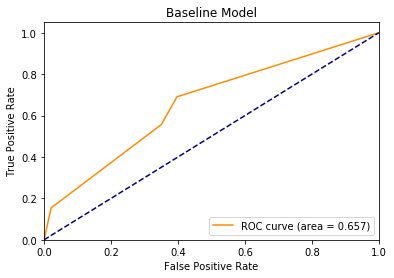

In [687]:
fig, ax = plt.subplots()
plt.plot(fpr_b, tpr_b, color='darkorange', label= f'ROC curve (area = {round(roc_auc_b, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Baseline Model')
plt.legend(loc="lower right")
plt.show()

### Current Top Model - rep and loyalty scores

In [688]:
# TRAIN
X_train_t = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train_t = sample_train['vote']

# TEST
X_test_t = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test_t = sample_test['vote']

In [689]:
top_model = RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=2, random_state=709)
top_model.fit(X_train_t, y_train_t)
y_pred_t = (top_model.predict_proba(X_test_t))[:, 1]

In [690]:
log_loss(y_test_t, y_pred_t)

0.36825452212685983

In [691]:
y_pred_t.min()

0.5900928736147553

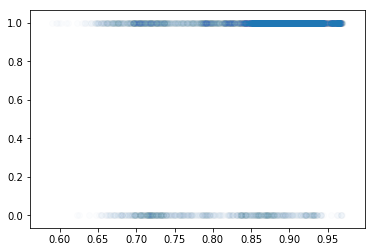

In [692]:
fig, ax = plt.subplots()
ax.scatter(y_pred_t, y_test_t, alpha=0.01)

In [693]:
fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t, y_pred_t)

In [694]:
roc_auc_t = roc_auc_score(y_test_t, y_pred_t)
roc_auc_t

0.7576100711936306

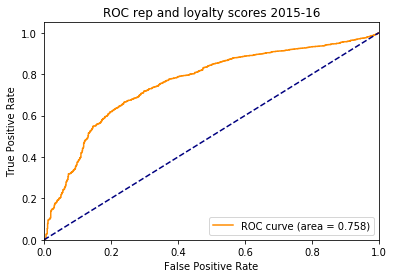

In [695]:
fig, ax = plt.subplots()
plt.plot(fpr_t, tpr_t, color='darkorange', label= f'ROC curve (area = {round(roc_auc_t, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

### Playground

In [738]:
# TRAIN
X_train = sample_train[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_train = sample_train['vote']

# TEST
X_test = sample_test[['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district', 
                     'party', 'is_primary_sponsor', 'is_secondary_sponsor', 'is_minority_party', 
                     'primary_sponsor_party', 'rep_score', 'loyalty_score', 'bill_length', 'bill_num']]

y_test = sample_test['vote']

In [735]:
bills = sample_train['bill_text']
bills_test = sample_test['bill_text']
len(bills)

188446

In [729]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.85, max_features=5000)

In [730]:
fitted = tf.fit(bills)

In [731]:
transformed_train = tf.transform(bills)

In [736]:
transformed_test = tf.transform(bills_test)

In [737]:
def tfidf_transformed_to_dataframe(transformed):
    tfidf_cols = transformed.toarray()
    tfidf_names = fitted.get_feature_names()
    tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

    return tfidf_df

In [ ]:
tfidf_train_df = tfidf_transformed_to_dataframe(transformed_train)
X_train = pd.concat([X_train, tfidf_train_df], axis=1)

In [ ]:
tfidf_test_df =  tfidf_transformed_to_dataframe(transformed_test)
X_test = pd.concat([X_test, tfidf_test_df], axis=1)

In [ ]:
X_train.head()

In [616]:
model = RandomForestClassifier(n_estimators=1000, max_depth=7, n_jobs=2, random_state=709)
model.fit(X_train, y_train)
y_pred = (model.predict_proba(X_test))[:, 1]

In [617]:
log_loss(y_test, y_pred)

0.1983155196831262

In [618]:
y_pred.min()

0.03100391174000697

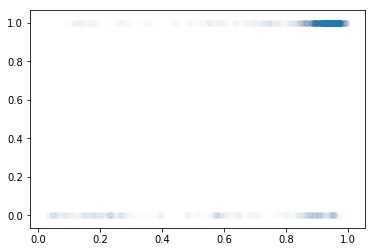

In [619]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, alpha=0.01)

In [620]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [621]:
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.9259090619001566

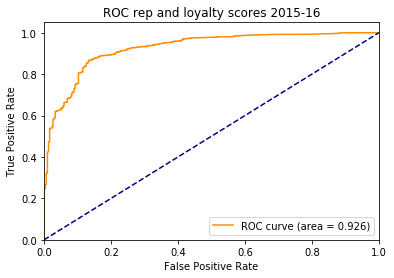

In [622]:
fig, ax = plt.subplots()
plt.plot(fpr, tpr, color='darkorange', label= f'ROC curve (area = {round(roc_auc, 3)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC rep and loyalty scores 2015-16')
plt.legend(loc="lower right")
plt.show()

In [704]:
features_importances = pd.DataFrame(model.feature_importances_, index=X_tf.columns)

In [701]:
X_tf.columns

Index(['voter_id', 'voting_agency', 'unique_id', 'sponsor_agency', 'district',
       'party', 'is_primary_sponsor', 'is_secondary_sponsor',
       'is_minority_party', 'primary_sponsor_party',
       ...
       'writing', 'wsipp', 'yakima', 'youth', 'youth homelessness',
       'youth school', 'youth state', 'youth suicide', 'zone', 'zones'],
      dtype='object', length=5014)

In [717]:
features_importances_sorted = features_importances.sort_values(by=0, ascending=False)

In [82]:
group = sample_one_year.groupby('vote')

In [83]:
group.mean()

,voter_id,voting_agency,unique_id,sponsor_agency,district,party,is_primary_sponsor,is_minority_party,is_secondary_sponsor,primary_sponsor_party,rep_score,dem_score,loyalty_score,bill_length,congress_num,num_sponsors
vote,,,,,,,,,,,,,,,,
0,12764.500000,0.242970,95725.262434,0.372211,21.795257,0.675323,0.006354,0.681527,0.035875,0.345392,0.343283,0.656717,0.028993,89470.724657,25.0,49.462574
1,11852.213699,0.328381,96010.719466,0.437821,25.332724,0.464220,0.010168,0.458261,0.059066,0.503617,0.422854,0.577146,0.091834,27339.572184,25.0,39.920609


# Explore bill_text

In [188]:
nays = sample[sample['vote'] == 0]
yeas = sample[sample['vote'] == 1]

nays.head()
yeas.head()

In [197]:
# print(nays.loc[2132532, 'bill_text'])

In [196]:
# print(yeas.loc[2840240, 'bill_text'])

In [220]:
example_text = yeas.loc[2840240, 'bill_text']

In [223]:
example_text.replace('\n', ' ')

'ENGROSSED SUBSTITUTE HOUSE BILL 1761State of Washington64th Legislature2015 Regular SessionBy House Business & Financial Services (originally sponsored by Representatives Stanford, Vick, Kirby, Parker, Ryu, G. Hunt, Blake, Santos, and Hurst)READ FIRST TIME 02/20/15.AN ACT Relating to insurance producers, insurers, and title insurance agents activities with customers and potential customers; amending RCW 48.30.140 and 48.30.150; and adding new sections to chapter 48.30 RCW.BE IT ENACTED BY THE LEGISLATURE OF THE STATE OF WASHINGTON:Sec.\xa01.\xa0\xa0RCW 48.30.140 and 2009 c 329 s 1 are each amended to read as follows:(1) Except to the extent provided for in an applicable filing with the commissioner then in effect, no insurer, insurance producer, or title insurance agent shall, as an inducement to insurance, or after insurance has been effected, directly or indirectly, offer, promise, allow, give, set off, or pay to the insured or to any employee of the insured, any rebate, discount, a

### TFIDFVectorizer

In [623]:
bills = sample_one_year['bill_text']

In [624]:
bills.shape

(184615,)

In [625]:
wordnet = WordNetLemmatizer()

In [626]:
def create_bill_tokens(bill):
    bill = bill.replace('\n', ' ') 
    punctuations = set(string.punctuation)
    
    bill = ''.join([char.lower() for char in bill if char not in punctuations])
    bill_tokens = bill.split(' ')
    lemmed_bill = [wordnet.lemmatize(word) for word in bill_tokens] 
    
    return lemmed_bill

In [726]:
my_stopwords = ['shall', 'chapter', 'provided', 'year', 'person', 'department', 'appropriation', 'provided'
                 'information', 'provide', 'including', 'following', 'section', 'sec', 'year', 'subsection', 
                'agency', 'required',  'use', 'solely', 'ii', 'defined', 'approved', 'does',  'period', 
                'rcw 43', 'persons', 'individual', 'unless', '9a', '28a', 'purpose', '28b',  'washington',  
                'fy',  'iii', 'sec rcw', 'rcw9a', 'rcw',  'apply',  '000general',  '000', 'related',  'sp', 
                'make', 'includes', 'end', 'biennia', 'set', 'terms', 'total', 'level', 'amended', 
                'engrossed', 'substitute', 'legislature', 'enacted', 'passed', 'add', 'additional', 'new', 'board',
                'limited', 'date', 'order', 'plan', 'percent', 'support', 'director', 'child', 'two', 'years', 
                'committee', 'five', 'laws', 'contract', 'prior', 'necessary', 'requirements', 'days', 'based', 
                'made', 'except', 'per', 'number', 'amounts', 'conditions', 'senate', 'house', 'system', 'may',
               'must', 'account', 'one', 'means', 'within', 'county', 'general', 'subject', 'within', 'treatment', 
               'service', 'include', 'used', 'account', 'less', 'part', 'member', 'established', 'law', 'rate', 
                'read', 'follows', 'information', 'program', 'services', 'fund', 'amount', 'agreement', 'payment',
               'commission', 'notice', 'legislature2015', '02', '1st', 'april', 'beginning', 'december', 'january', 
                'february', 'march', 'may', 'june', 'july', 'august', 'sepetmeber', 'november', 'manner', 'plans',
               'need', '060', 'sections', 'either', 'described', 'equivalent', 'recommendations', 'office', 'created',
               'higher', 'hours', 'written', 'address', 'organizations', 'value', 'party', 'full', '030', 'high', 'case',
               'four', '04', 'would', '05', 'day', 'whether', 'pass', '040']

stop_nums = list(set([str(num) for num in range(0, 2025)]))
stopwords_nltk = list(set(stopwords.words('english')))

In [628]:
stopwords_nltk.extend(my_stopwords)
stopwords_nltk.extend(stop_nums)
stopwords_nltk = set(stopwords_nltk)

In [629]:
analyzer=create_bill_tokens, 

In [ ]:
tf = TfidfVectorizer(stop_words=stopwords_nltk, ngram_range=(1, 2), max_df=0.9, max_features=5000)

fitted = tf.fit(bills)

transformed = tf.transform(bills)

fitted = tf.fit(bills)

transformed = tf.transform(bills)

vocab = tf.vocabulary_

vocab

tfidf_cols = transformed.toarray()

tfidf_names = fitted.get_feature_names()

tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

tfidf_df.head()

tfidf_df.shape

In [631]:
fitted = tf.fit(bills)

KeyboardInterrupt: 

In [571]:
transformed = tf.transform(bills)

In [572]:
vocab = tf.vocabulary_

In [573]:
vocab

{'certification': 882,
 '201564th': 180,
 'sessionstate': 4170,
 'building': 759,
 'code': 977,
 'climate': 965,
 'short': 4205,
 'gregerson': 2286,
 '08': 160,
 '01': 114,
 'referred': 3777,
 'local': 2843,
 'government': 2245,
 'counties': 1270,
 'zones': 4999,
 'purposes': 3658,
 'amending': 419,
 '031': 131,
 '020': 123,
 'creating': 1293,
 'finds': 2041,
 'council': 1264,
 'adopted': 324,
 'rule': 4019,
 'changes': 894,
 'codes': 982,
 'due': 1567,
 'modifications': 3037,
 'international': 2611,
 'energy': 1722,
 'conservation': 1128,
 'intends': 2595,
 'update': 4834,
 'statutes': 4450,
 'national': 3089,
 'standards': 4323,
 'otherwise': 3241,
 'effect': 1635,
 'cities': 931,
 'consist': 1138,
 'hereby': 2361,
 'reference': 3773,
 'published': 3647,
 'residential': 3927,
 'mechanical': 2958,
 'gas': 2213,
 'installations': 2548,
 'storage': 4462,
 'fuel': 2162,
 'fire': 2042,
 'protection': 3598,
 'association': 549,
 'specifically': 4274,
 'referenced': 3774,
 'notwithstanding'

In [574]:
tfidf_cols = transformed.toarray()

In [575]:
tfidf_names = fitted.get_feature_names()

In [576]:
tfidf_df = pd.DataFrame(tfidf_cols, columns=tfidf_names)

In [577]:
tfidf_df.head()

,00,00 00,00 grades,00 month,000accident,000accident state,000air,000appropriation,000appropriation state,000aquatic,...,writing,wsipp,yakima,youth,youth homelessness,youth school,youth state,youth suicide,zone,zones
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.016819,0.0,0.0,0.0,0.0,0.0,0.107762,0.046184
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


In [586]:
tfidf_df.shape

(10000, 5000)

In [404]:
# cv = CountVectorizer(stop_words=stopwords_nltk, analyzer='word', ngram_range=(1, 4), max_df=0.9, max_features = 200000)
# cv_fit = cv.fit_transform(bills)
# word_counts = pd.DataFrame(cv_fit.toarray(), columns= cv.get_feature_names())
# word_counts = word_counts.sum(axis=0)
# words_sorted = word_counts.sort_values(ascending=False)
# words_sorted_only = words_sorted.index
# for word in words_sorted_only [100:150]:
#     print(word)

In [719]:
features_importances_sorted[0:50]

,0
loyalty_score,0.152837
party,0.126456
is_minority_party,0.114013
district,0.068795
voter_id,0.041813
calculated,0.007624
california,0.007289
base,0.006926
front,0.005846
tool,0.005372
